Forms .csv data of the following mentioned  columns:
1.  Aircraft
2.  Type Of Traveller
3.  Seat Type
4.  Route
5.  Date Flown
6.  Seat Comfort
7.  Cabin Staff Service
8.  Food & Beverages
9.  Ground Service
10. Inflight Entertainment
11. Wifi & Connectivity
12. Value For Money
13. Recommended

In [1]:
import time
import random
import unicodedata
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
# 1) Fetch airline names A–Z
def fetch_airline_names():
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/80.0.3987.162 Safari/537.36"
        )
    }
    names = []
    for letter in map(chr, range(ord('A'), ord('Z')+1)):
        url = (
            f"https://www.airlinequality.com/"
            f"review-pages/a-z-airline-reviews/#a2z-ldr-{letter}"
        )
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "lxml")
        container = soup.find("div", id=f"a2z-ldr-{letter}")
        if not container:
            continue
        for li in container.find_all("li"):
            names.append(li.text.strip())
        time.sleep(random.uniform(0.5, 1.5))
    return names

# 2) Build review‑page URLs from names
def build_urls(names):
    base = "https://www.airlinequality.com/airline-reviews/"
    suffix = "?sortby=post_date%3ADesc&pagesize=100"
    urls = []
    for name in names:
        slug = unicodedata.normalize('NFKD', name.lower()) \
                          .encode('ascii','ignore') \
                          .decode('utf-8')
        slug = slug.replace(" ", "-")
        urls.append(f"{base}{slug}/{suffix}")
    return urls

# 3) Configure session with retries
def make_session():
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/80.0.3987.162 Safari/537.36"
        )
    }
    session = requests.Session()
    session.headers.update(headers)
    retries = Retry(
        total=5,
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    adapter = HTTPAdapter(max_retries=retries)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

# 4) Scrape reviews for one airline URL
def scrape_reviews_for(url, session):
    try:
        r = session.get(url, timeout=10)
    except requests.RequestException:
        return []

    if r.status_code == 404:
        return []
    try:
        r.raise_for_status()
    except requests.HTTPError:
        return []

    soup = BeautifulSoup(r.text, "html.parser")
    container = soup.find(
        "article",
        class_="comp comp_reviews-airline querylist position-content"
    )
    if not container:
        return []

    reviews = []
    cols = [
        "Aircraft","Type Of Traveller","Seat Type","Route","Date Flown",
        "Seat Comfort","Cabin Staff Service","Food & Beverages","Ground Service",
        "Inflight Entertainment","Wifi & Connectivity","Value For Money","Recommended"
    ]

    for item in container.find_all("article"):
        overall = None
        title = None
        review_date = None
        verified = False
        text = None
        ratings = [None] * len(cols)

        rdiv = item.find("div", class_="rating-10")
        if rdiv:
            overall = rdiv.text.strip()[:1]

        h2 = item.find("h2")
        if h2:
            title = h2.text.strip()

        h3 = item.find("h3")
        if h3 and h3.find("time"):
            review_date = h3.find("time").text.strip()

        tdiv = item.find("div", class_="text_content")
        if tdiv:
            parts = tdiv.text.strip().split("|", 1)
            if parts[0].startswith("✅"):
                verified = True
                text = parts[1].strip() if len(parts) > 1 else ""
            else:
                text = parts[0].strip()

        table = item.find("table")
        if table:
            for tr in table.find_all("tr"):
                cells = tr.find_all("td")
                if len(cells) < 2:
                    continue
                cat = cells[0].text.strip()
                if cat in cols:
                    idx = cols.index(cat)
                    stars = cells[1].find_all("span", class_="star fill")
                    if stars:
                        ratings[idx] = len(stars)
                    else:
                        ratings[idx] = cells[1].text.strip()

        reviews.append([
            overall, title, review_date, verified, text, *ratings
        ])

    return reviews

def main():
    names = fetch_airline_names()
    urls  = build_urls(names)

    df_airlines = pd.DataFrame({"Name": names, "URL": urls})
    df_airlines.to_csv("data/airline_list.csv", index=False)

    session = make_session()
    all_reviews = []
    cols = [
        "Overall_Rating","Review_Title","Review Date","Verified","Review",
        "Aircraft","Type Of Traveller","Seat Type","Route","Date Flown",
        "Seat Comfort","Cabin Staff Service","Food & Beverages","Ground Service",
        "Inflight Entertainment","Wifi & Connectivity","Value For Money","Recommended"
    ]

    for idx, (name, url) in enumerate(zip(names, urls), 1):
        print(f"[{idx}/{len(names)}] {name}")
        reviews = scrape_reviews_for(url, session)
        for r in reviews:
            all_reviews.append([name, *r])
        time.sleep(random.uniform(1, 3))

    df = pd.DataFrame(all_reviews, columns=["Airline Name", *cols])
    df.to_csv("data/Airline_review.csv", index=False)
    print(f"\n✅ Saved {len(df)} reviews to data/Airline_review.csv")

if __name__ == "__main__":
    main()

[1/572] AB Aviation
[2/572] Adria Airways
[3/572] Aegean Airlines
[4/572] Aer Lingus
[5/572] Aero VIP
[6/572] Aerocaribbean
[7/572] Aeroflot Russian Airlines
[8/572] AeroItalia
[9/572] Aerolineas Argentinas
[10/572] Aeromar
[11/572] Aeromexico
[12/572] Aerosur
[13/572] Africa World Airlines
[14/572] Afriqiyah Airways
[15/572] Aigle Azur
[16/572] Air Algerie
[17/572] Air Antilles
[18/572] Air Arabia
[19/572] Air Astana
[20/572] Air Austral
[21/572] Air Bagan
[22/572] Air Belgium
[23/572] Air Berlin
[24/572] Air Botswana
[25/572] Air Burkina
[26/572] Air Busan
[27/572] Air Cairo
[28/572] Air Canada
[29/572] Air Canada rouge
[30/572] Air Caraibes
[31/572] Air China
[32/572] Air Corsica
[33/572] Air Costa
[34/572] Air Cote d'Ivoire
[35/572] Air Djibouti
[36/572] Air Dolomiti
[37/572] Air Europa
[38/572] Air France
[39/572] Air Greenland
[40/572] Air Iceland Connect
[41/572] Air India
[42/572] Air India Express
[43/572] Air Italy
[44/572] Air Juan
[45/572] Air KBZ
[46/572] Air Koryo
[47/572

Scrapes and Saves Reviews in text  form of each Airline

In [ ]:
import os
import time
import random
import unicodedata
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize
from urllib.parse import quote_plus

nltk.download('punkt')

DATA_DIR = "Data"
os.makedirs(DATA_DIR, exist_ok=True)

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/80.0.3987.162 Safari/537.36"
    )
}

def fetch_airline_names():
    names = []
    for letter in map(chr, range(ord('A'), ord('Z')+1)):
        url = (
            f"https://www.airlinequality.com/"
            f"review-pages/a-z-airline-reviews/#a2z-ldr-{letter}"
        )
        resp = requests.get(url, headers=HEADERS, timeout=10)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, 'html.parser')
        container = soup.find("div", {"id": f"a2z-ldr-{letter}"})
        if not container:
            continue
        for li in container.find_all("li"):
            names.append(li.text.strip())
        time.sleep(random.uniform(0.5, 1.0))
    return names

def make_review_url(name, page=1):
    slug = unicodedata.normalize('NFKD', name.lower()) \
                      .encode('ascii','ignore').decode('utf-8')
    slug = slug.replace(" ", "-")
    base = f"https://www.airlinequality.com/airline-reviews/{quote_plus(slug)}/"
    if page > 1:
        base += f"page/{page}/"
    return f"{base}?sortby=post_date%3ADesc&pagesize=100"

def clean_text(text):
    sents = sent_tokenize(text)
    cleaned = []
    for s in sents:
        s = s.strip().strip('“”"\'')
        if s:
            cleaned.append(s)
    return " ".join(cleaned)

def scrape_and_save(name):
    """Scrape ALL pages for a single airline and write titles+reviews to {name}.txt"""
    filename = os.path.join(DATA_DIR, f"{name.replace('/', '_')}.txt")
    with open(filename, "w", encoding="utf-8") as f_out:
        page = 1
        while True:
            url = make_review_url(name, page)
            resp = requests.get(url, headers=HEADERS, timeout=10)
            if resp.status_code == 404:
                break
            resp.raise_for_status()

            soup = BeautifulSoup(resp.text, 'html.parser')
            container = soup.find(
                "article",
                class_="comp comp_reviews-airline querylist position-content"
            )
            if not container:
                break

            reviews = container.find_all("article")
            if not reviews:
                break

            for item in reviews:
                h2 = item.find("h2")
                title = h2.text.strip() if h2 else "No Title"

                div = item.find("div", class_="text_content")
                raw = div.text.strip() if div else ""

                if raw.startswith("✅"):
                    parts = raw.split("|", 1)
                    raw = parts[1] if len(parts) > 1 else ""

                cleaned = clean_text(raw)

                f_out.write(f"### {title}\n")
                f_out.write(cleaned + "\n\n")

            page += 1
            time.sleep(random.uniform(1, 2))

    print(f"Saved reviews for {name} → {filename}")

def main():
    airline_names = fetch_airline_names()
    for idx, name in enumerate(airline_names, 1):
        print(f"[{idx}/{len(airline_names)}] {name}")
        try:
            scrape_and_save(name)
        except Exception as e:
            print(f"  Error scraping {name}: {e}")
        time.sleep(random.uniform(2, 4))

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to C:\Users\Samay
[nltk_data]     Mehar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[1/572] AB Aviation
Saved reviews for AB Aviation → Data\AB Aviation.txt
[2/572] Adria Airways
Saved reviews for Adria Airways → Data\Adria Airways.txt
[3/572] Aegean Airlines
  Error scraping Aegean Airlines: HTTPSConnectionPool(host='www.airlinequality.com', port=443): Read timed out. (read timeout=10)
[4/572] Aer Lingus
Saved reviews for Aer Lingus → Data\Aer Lingus.txt
[5/572] Aero VIP
Saved reviews for Aero VIP → Data\Aero VIP.txt
[6/572] Aerocaribbean
Saved reviews for Aerocaribbean → Data\Aerocaribbean.txt
[7/572] Aeroflot Russian Airlines
Saved reviews for Aeroflot Russian Airlines → Data\Aeroflot Russian Airlines.txt
[8/572] AeroItalia
Saved reviews for AeroItalia → Data\AeroItalia.txt
[9/572] Aerolineas Argentinas
Saved reviews for Aerolineas Argentinas → Data\Aerolineas Argentinas.txt
[10/572] Aeromar
Saved reviews for Aeromar → Data\Aeromar.txt
[11/572] Aeromexico
Saved reviews for Aeromexico → Data\Aeromexico.txt
[12/572] Aerosur
Saved reviews for Aerosur → Data\Aerosur.tx

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go

%matplotlib inline
sns.set_style("whitegrid")

In [ ]:
csv_path      = r"D:/Projects2.0/British Airways/Data/Airline_review.csv"
airline_csv   = r"D:/Projects2.0/British Airways/Data/airline_list.csv"
reviews_folder = r"D:/Projects2.0/British Airways/Data/Reviews"

df_reviews    = pd.read_csv(csv_path, parse_dates=["Review Date"])
df_airlines   = pd.read_csv(airline_csv)

print(df_reviews.shape, df_airlines.shape)
df_reviews.head()

(24403, 24) (572, 2)


,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,...,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Review
0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,NaN,Solo Leisure,Economy Class,Moroni to Moheli,Nov-19,...,NaN,NaN,3.0,yes,NaN,NaN,NaN,NaN,NaN,Moroni to Moheli. Turned out to be a pretty de...
1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,E120,Solo Leisure,Economy Class,Moroni to Anjouan,Jun-19,...,NaN,NaN,2.0,no,NaN,NaN,NaN,NaN,NaN,Moroni to Anjouan. It is a very small airline....
2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,Jun-19,...,NaN,NaN,2.0,no,NaN,NaN,NaN,NaN,NaN,Anjouan to Dzaoudzi. A very small airline and ...
3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,Sep-19,...,NaN,NaN,1.0,no,NaN,NaN,NaN,NaN,NaN,Not Verified
4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,Sep-19,...,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN,NaN,Do not book a flight with this airline! My fri...


In [ ]:
txt_files = { os.path.splitext(os.path.basename(p))[0]: p 
              for p in glob.glob(os.path.join(reviews_folder, "*.txt")) }

missing      = []
empty_count  = 0
for name in df_airlines["Name"]:
    key = name
    if key not in txt_files:
        missing.append(name)
    else:
        if os.path.getsize(txt_files[key]) == 0:
            empty_count += 1

print(f"Missing files: {len(missing)} airlines")
print(f"Empty files:   {empty_count} airlines")

Missing files: 0 airlines
Empty files:   65 airlines


In [ ]:
import re

def clean_numeric_series(s):
    cleaned = s.astype(str).str.replace(r"[^\d\.]", "", regex=True)
    return pd.to_numeric(cleaned, errors="coerce")

df_reviews["Overall_Rating_Clean"] = clean_numeric_series(df_reviews["Overall_Rating"])

print("Before cleaning:", df_reviews["Overall_Rating"].dtype, "  After:", df_reviews["Overall_Rating_Clean"].dtype)
print("Converted values:", df_reviews["Overall_Rating_Clean"].head(10))

Before cleaning: object   After: float64
Converted values: 0    9.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    8.0
Name: Overall_Rating_Clean, dtype: float64


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
valid_reviews = df_reviews.dropna(subset=["Overall_Rating_Clean"])

avg_rating        = valid_reviews["Overall_Rating_Clean"].mean()
verification_rate = valid_reviews["Verified"].mean() * 100
total_reviews     = len(valid_reviews)
unique_routes     = valid_reviews["Route"].nunique()

metrics = {
    "Average Rating":    f"{avg_rating:.2f}/10", 
    "Verified Reviews":  f"{verification_rate:.1f}%", 
    "Total Reviews":     total_reviews, 
    "Unique Routes":     unique_routes
}
from pprint import pprint
pprint(metrics)
# ──────────────────────────────────────────────────────────────────────────────

{'Average Rating': '3.10/10',
 'Total Reviews': 23592,
 'Unique Routes': 14082,
 'Verified Reviews': '61.8%'}


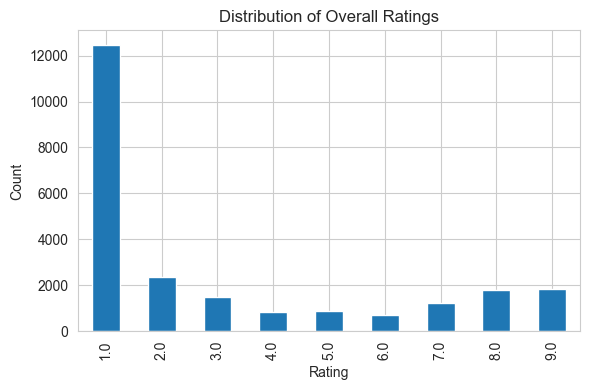

In [ ]:
plt.figure(figsize=(6,4))
df_reviews["Overall_Rating_Clean"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Overall Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Index(['Route', 'Count'], dtype='object')


C:\Users\Samay Mehar\AppData\Local\Temp\ipykernel_14732\2536519095.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


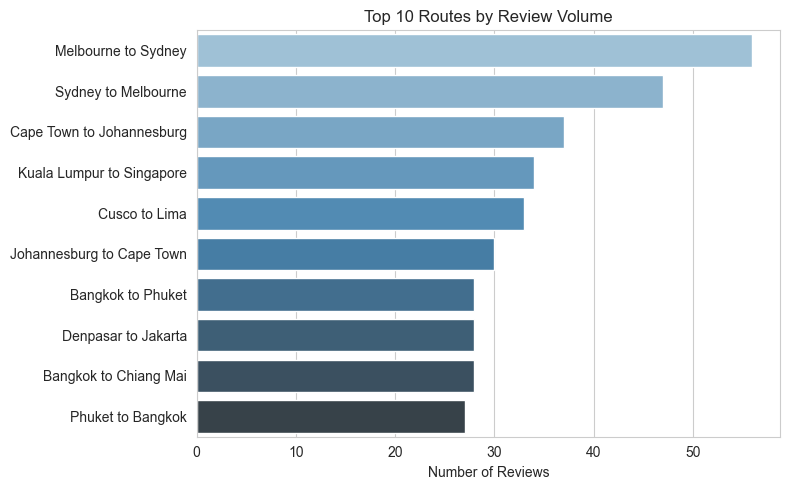

In [ ]:
top_routes = (
    df_reviews["Route"]
    .value_counts()
    .nlargest(10)
    .reset_index(name="Count")      
    .rename(columns={"index": "Route"})
)

print(top_routes.columns)
plt.figure(figsize=(8,5))
sns.barplot(
    data=top_routes,
    y="Route",                      
    x="Count",                      
)
plt.title("Top 10 Routes by Review Volume")
plt.xlabel("Number of Reviews")
plt.ylabel("")                     
plt.tight_layout()
plt.show()


In [20]:
# Cell 7: Verified vs. Non-Verified (Plotly)
verified_counts = df_reviews["Verified"].value_counts().rename({True:"Verified", False:"Not Verified"})
fig = go.Figure(data=[go.Pie(labels=verified_counts.index,
                             values=verified_counts.values,
                             hole=0.4)])
fig.update_layout(title_text="Proportion of Verified Reviews")
fig.show()

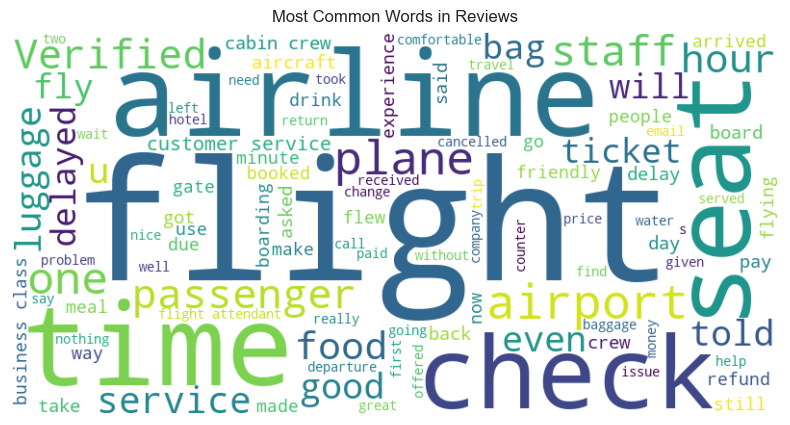

In [ ]:
all_text = " ".join(df_reviews["Review"].astype(str).tolist())
wc = WordCloud(stopwords=STOPWORDS, max_words=100,
               background_color="white", width=800, height=400)
wc.generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
csv_path      = r"D:/Projects2.0/British Airways/Data/Airline_review.csv"
airline_list  = r"D:/Projects2.0/British Airways/Data/airline_list.csv"

df = pd.read_csv(csv_path)

df = df.drop_duplicates()

df["Overall_Rating"] = pd.to_numeric(df["Overall_Rating"], errors="coerce")
df["Value For Money"] = pd.to_numeric(df["Value For Money"], errors="coerce")

airlines = pd.read_csv(airline_list)["Name"].unique().tolist()

In [ ]:
df["Overall_Rating"]    = pd.to_numeric(df["Overall_Rating"],    errors="coerce")
df["Value For Money"]   = pd.to_numeric(df["Value For Money"],   errors="coerce")

agg = (
    df
    .groupby("Airline Name")
    .agg(
        avg_rating      = ("Overall_Rating",  "mean"),
        avg_value_money = ("Value For Money", "mean"),
        review_count    = ("Value For Money", "count")
    )
    .reset_index()
)

agg = agg.dropna(subset=["avg_rating", "avg_value_money"])

In [ ]:
fig_px = px.scatter(
    agg,
    x="avg_value_money",
    y="avg_rating",
    size="review_count",
    hover_name="Airline Name",
    size_max=60,
    color="avg_rating",
    color_continuous_scale="Viridis",
    labels={
        "avg_value_money": "Avg. Value For Money",
        "avg_rating":      "Avg. Overall Rating",
        "review_count":    "No. of Reviews"
    },
    title="Airline Satisfaction vs. Value For Money"
)
fig_px.update_layout(
    font=dict(size=14),
    title_font_size=18,
    legend_title_text="Avg. Rating"
)
fig_px.show()

In [ ]:
fig_go = go.Figure()

fig_go.add_trace(go.Scatter(
    x=agg["avg_value_money"],
    y=agg["avg_rating"],
    mode="markers",
    marker=dict(
        size=agg["review_count"] / agg["review_count"].max() * 80 + 10,
        color=agg["avg_value_money"],
        colorscale="Cividis",
        showscale=True,
        colorbar=dict(title="Avg. Value"),
        opacity=0.7,
        line=dict(width=1, color="DarkSlateGrey")
    ),
    text=agg["Airline Name"],
    hovertemplate=(
        "<b>%{text}</b><br>"
        "Avg. Rating: %{y:.2f}<br>"
        "Avg. Value:  %{x:.2f}<br>"
        "Reviews:     %{marker.size:.0f}<extra></extra>"
    )
))

fig_go.update_layout(
    title="Bubble Chart: Value For Money vs. Overall Satisfaction",
    xaxis_title="Avg. Value For Money",
    yaxis_title="Avg. Overall Rating",
    xaxis=dict(gridcolor="lightgrey"),
    yaxis=dict(gridcolor="lightgrey"),
    template="plotly_white",
    font=dict(family="Arial", size=13)
)

fig_go.show()